Import the Libraries to load the data to do manipulation and visualization and model creation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import copy
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import json
import os
from tqdm import tqdm
from torch.utils.data import Dataset
from collections import Counter
import os
from torchvision import datasets
import random
import torch.nn as nn
from torch.nn import functional as F


sdir defines the directory of the data
where the data is divides into 4 parts
1. train
2. test
3. Validation
4. Json file containing labels

Here the 5th path is balanced train that i have created with data augmentation as the process for data augmentation.

In [2]:
sdir = r'/content/drive/MyDrive/data'
classes = []
dataset = os.listdir(sdir)
print(dataset)

['cat_to_name.json', 'validation', 'test', 'train', 'balanced_train']


Transform the data this image size,mean and standard deviation values and specific for the pretrained model that i have used in the further process

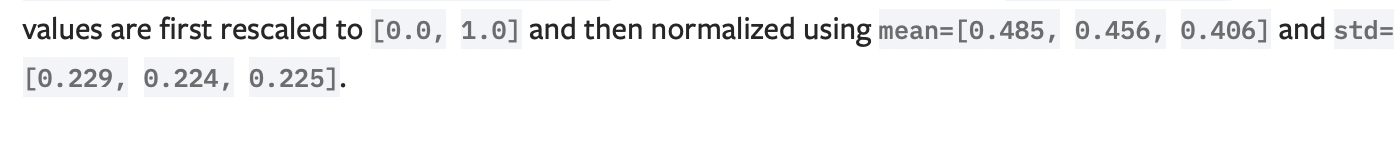

In [3]:
sdir = r'/content/drive/MyDrive/data'
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


now change the paths to the datasets and then make the dataloader so we can use functions like shuffle and batch size

In [4]:

cat_to_name_path = os.path.join(sdir, 'cat_to_name.json')
with open(cat_to_name_path, 'r') as f:
    cat_to_name = json.load(f)

train_dir = os.path.join(sdir, 'train')
valid_dir = os.path.join(sdir, 'validation')
test_dir = os.path.join(sdir, 'test')

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)
batch_size = 600
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [5]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = np.clip(image, 0, 1)
    return image



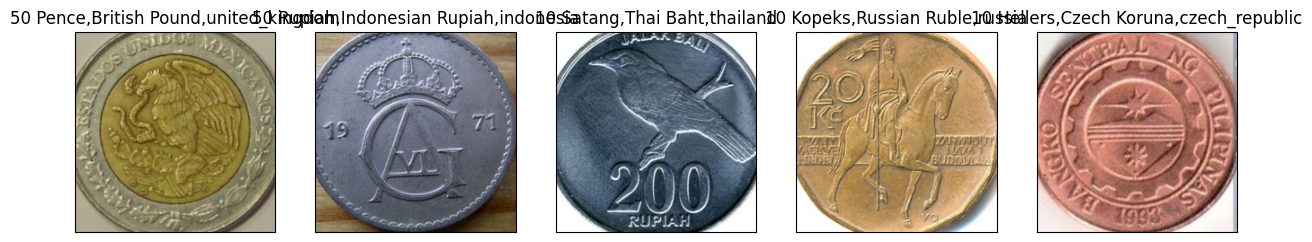

In [47]:
dataiter = iter(train_loader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15, 6))
for idx in range(5):
  ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(unnormalize(images[idx]))
  ax.set_title(cat_to_name[str(labels[idx].item())])
plt.show()

now to see if the data is balanced check the distribution of the data(images) into classes

In [13]:

def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts


In [33]:
def plot_class_distribution(train_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
    plt.xlabel(" Classes")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Flower Images in Training Dataset")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


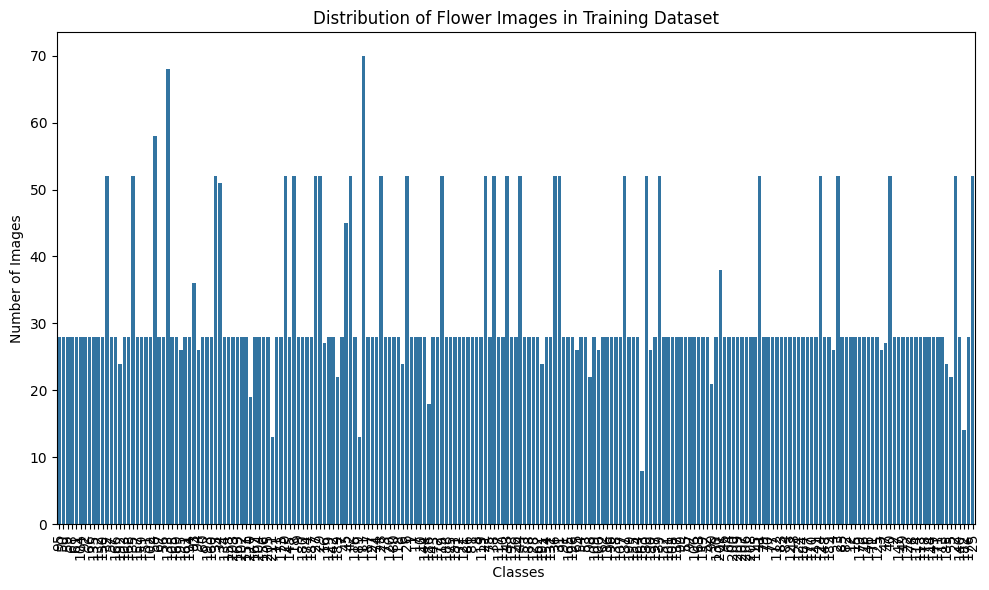

In [34]:
plot_class_distribution(count_images_per_class(train_dir))


here the data is seems to be not balancd to balance the data find of the best possible number of images for each class in this case i have checked the mode fuction to find the most used number of images for a class.

In [11]:
import statistics
print('Most of the classes have {} images'.format(statistics.mode(class_counts_values)))
print('The least number of images a class have is {}'.format(min(class_counts_values)))

Most of the classes have 28 images
The least number of images a class have is 8


Create a directory  where the balanced data will be stored after the augmentation

In [12]:

balanced_train_dir = os.path.join(sdir, 'balanced_train')

cat_to_name_path = os.path.join(sdir, 'cat_to_name.json')
with open(cat_to_name_path, 'r') as f:
    cat_to_name = json.load(f)
if not os.path.exists(balanced_train_dir):
    os.makedirs(balanced_train_dir)


Here i have created functions for both image generation and image removal that takes the number of images extra or less than the required number(mode) and randomly select an image to remove or change.

In [15]:
def augment_images(class_dir, class_balanced_dir, images, num_to_generate):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
    ])

    for i in range(num_to_generate):
        random_image = random.choice(images)
        source_path = os.path.join(class_dir, random_image)

        try:
            img = Image.open(source_path).convert('RGB')
            img_transformed = transform(img)

            new_image_name = f"{random_image[:-4]}_generated_{i}.jpg"
            destination_path = os.path.join(class_balanced_dir, new_image_name)
            img_transformed.save(destination_path)
        except Exception as e:
            print(f"Error generating image: {e}")

In [16]:
def remove_images(class_balanced_dir, num_to_remove):
    images = os.listdir(class_balanced_dir)
    images_to_remove = random.sample(images, num_to_remove)
    for image in images_to_remove:
        image_path = os.path.join(class_balanced_dir, image)
        os.remove(image_path)

the balanced_dataset takes the number of dataset count its mode and then  using the data genration and removal function completes the balancing process and saves the balanced data into the new balanced_train_data folder.

In [17]:
import shutil
import os
def balance_dataset(directory, mode):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            num_images = len(images)

            # Create corresponding class folder in balanced_train
            class_balanced_dir = os.path.join(balanced_train_dir, class_name)
            if not os.path.exists(class_balanced_dir):
                os.makedirs(class_balanced_dir)

            # Copy original images to balanced directory
            for image in images:
                original_image_path = os.path.join(class_dir, image)
                if os.path.isfile(original_image_path):
                    shutil.copy(original_image_path, class_balanced_dir)

            # If the class has fewer images than the mode, generate new images
            if num_images < mode:
                num_to_generate = mode - num_images
                print(f"Generating {num_to_generate} images for class {class_name}")
                augment_images(class_dir, class_balanced_dir, images, num_to_generate)
            # If the class has more images than the mode, remove excess images
            elif num_images > mode:
                num_to_remove = num_images - mode
                print(f"Removing {num_to_remove} images for class {class_name}")
                remove_images(class_balanced_dir, num_to_remove)

i have made this code as a comment because i have used this once to make the data balanced.

In [35]:
"""ﬁ
train_counts = count_images_per_class(train_dir)
mode = statistics.mode(train_counts.values())
print('Most of the images have {} images'.format(mode))

balance_dataset(train_dir, mode)



"\ntrain_counts = count_images_per_class(train_dir)\nmode = statistics.mode(train_counts.values())\nprint('Most of the images have {} images'.format(mode))\n\n# Balance the dataset and copy to 'balanced_train' folder\nbalance_dataset(train_dir, mode)\n\n"

Now one can see the data is balanced all the classes have 28 images and the data is ready to be used for the modle training process.

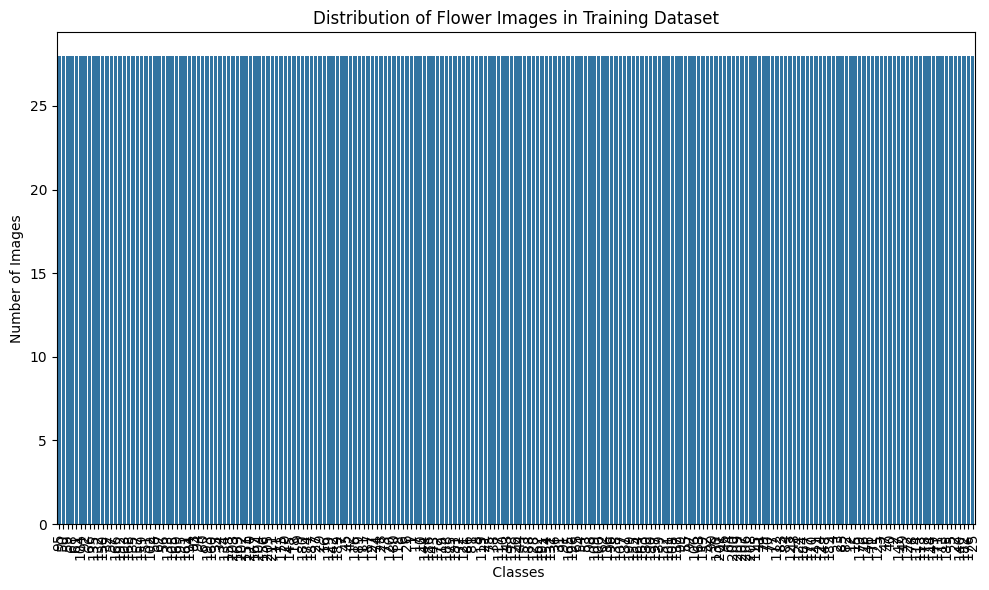

In [36]:
plot_class_distribution(count_images_per_class(balanced_train_dir))

make a dataloader from the balanced_train_data

In [6]:
balanced_train_dir = os.path.join(sdir, 'balanced_train')
new_train_data = datasets.ImageFolder(root=balanced_train_dir, transform=transform)
new_train_loader = DataLoader(new_train_data, batch_size=batch_size, shuffle=True)

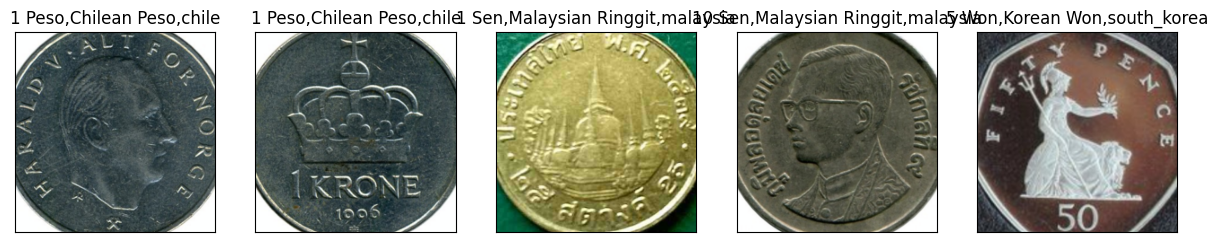

In [7]:
dataiter = iter(new_train_loader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15, 6))
for idx in range(5):
  ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(unnormalize(images[idx]))
  ax.set_title(cat_to_name[str(labels[idx].item())])
plt.show()

In [19]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


here i have defined the train_model function that takes model, criterion, optimizer, scheduler, train_loader, valid_loader, device, number_of_epochs to train the model it trains the model on the train data and after each epoch checks the performance on the validation data.

In [24]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, device, epochs=15):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                running_loss = 0.0
                running_corrects = 0

                # Use tqdm for training loop
                progress_bar = tqdm(train_loader, desc="Training", total=len(train_loader), ncols=100, unit="batch")

                # Iterate over data in the training set
                for inputs, labels in progress_bar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Compute loss
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Update progress bar with loss and accuracy
                    progress_bar.set_postfix(loss=running_loss / (len(labels) + 1e-8), acc=running_corrects.double() / (len(labels) + 1e-8), refresh=True)

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = running_corrects.double() / len(train_loader.dataset)

            else:  # Validation phase
                model.eval()  # Set model to evaluation mode
                running_loss = 0.0
                running_corrects = 0

                # Use tqdm for validation loop
                progress_bar = tqdm(valid_loader, desc="Validating", total=len(valid_loader), ncols=100, unit="batch")

                # No gradient computation during validation
                with torch.no_grad():
                    for inputs, labels in progress_bar:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # Forward pass
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)

                        # Compute loss
                        loss = criterion(outputs, labels)

                        # Statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                        # Update progress bar with loss and accuracy
                        progress_bar.set_postfix(loss=running_loss / (len(labels) + 1e-8), acc=running_corrects.double() / (len(labels) + 1e-8), refresh=True)

                epoch_loss = running_loss / len(valid_loader.dataset)
                epoch_acc = running_corrects.double() / len(valid_loader.dataset)

            # Print the statistics for each phase
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it has the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())



    # Total time taken
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

now as i am using pretrained model i have loaded the model from the torch library and then freeze the parameters for the pretrained model to train these parameters on the coin data i have add a dense(fully connected layer ) at the end where

In [26]:
model_conv = torchvision.models.efficientnet_b3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
num_features = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_features, 211)
model_conv = model_conv.to(device)




Now after defining the model need to define the lossfunction,optimizer and lr_scheduler (as the train fuction requires lr_scheduler)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.Adam(model_conv.classifier[1].parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Now to test the model's performance on the test data i have defined a function test.

In [27]:
def test():
  model_conv.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      # Move data and target to the same device as the model
      data, target = data.to(device), target.to(device)
      output = model_conv(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train the model usind the model function

In [29]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         new_train_loader,
                         valid_loader,
                         device,
                         epochs=25)




Epoch 1/25
----------


Training: 100%|█| 10/10 [1:07:39<00:00, 405.90s/batch, acc=tensor(0.9193, device='cuda:0', dtype=tor


train Loss: 5.1695 Acc: 0.0790


Validating: 100%|█| 2/2 [09:42<00:00, 291.17s/batch, acc=tensor(0.5205, device='cuda:0', dtype=torch


val Loss: 5.0936 Acc: 0.1505
Epoch 2/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.71s/batch, acc=tensor(5.5079, device='cuda:0', dtype=torch.


train Loss: 4.5523 Acc: 0.4736


Validating: 100%|█| 2/2 [00:07<00:00,  3.78s/batch, acc=tensor(1.7869, device='cuda:0', dtype=torch.


val Loss: 4.4640 Acc: 0.5166
Epoch 3/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.73s/batch, acc=tensor(7.4724, device='cuda:0', dtype=torch.


train Loss: 4.0096 Acc: 0.6425


Validating: 100%|█| 2/2 [00:07<00:00,  3.80s/batch, acc=tensor(2.0410, device='cuda:0', dtype=torch.


val Loss: 3.8873 Acc: 0.5900
Epoch 4/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.75s/batch, acc=tensor(8.2362, device='cuda:0', dtype=torch.


train Loss: 3.5157 Acc: 0.7082


Validating: 100%|█| 2/2 [00:07<00:00,  3.91s/batch, acc=tensor(2.2090, device='cuda:0', dtype=torch.


val Loss: 3.4323 Acc: 0.6386
Epoch 5/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.69s/batch, acc=tensor(8.5925, device='cuda:0', dtype=torch.


train Loss: 3.0775 Acc: 0.7388


Validating: 100%|█| 2/2 [00:07<00:00,  3.88s/batch, acc=tensor(2.2787, device='cuda:0', dtype=torch.


val Loss: 3.0628 Acc: 0.6588
Epoch 6/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.67s/batch, acc=tensor(8.8445, device='cuda:0', dtype=torch.


train Loss: 2.7135 Acc: 0.7605


Validating: 100%|█| 2/2 [00:07<00:00,  3.88s/batch, acc=tensor(2.3238, device='cuda:0', dtype=torch.


val Loss: 2.7627 Acc: 0.6718
Epoch 7/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.62s/batch, acc=tensor(9.0531, device='cuda:0', dtype=torch.


train Loss: 2.5024 Acc: 0.7784


Validating: 100%|█| 2/2 [00:07<00:00,  3.91s/batch, acc=tensor(2.3238, device='cuda:0', dtype=torch.


val Loss: 2.7357 Acc: 0.6718
Epoch 8/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.66s/batch, acc=tensor(9.0335, device='cuda:0', dtype=torch.


train Loss: 2.4754 Acc: 0.7767


Validating: 100%|█| 2/2 [00:07<00:00,  3.81s/batch, acc=tensor(2.3443, device='cuda:0', dtype=torch.


val Loss: 2.7138 Acc: 0.6777
Epoch 9/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.63s/batch, acc=tensor(9.1280, device='cuda:0', dtype=torch.


train Loss: 2.4419 Acc: 0.7849


Validating: 100%|█| 2/2 [00:07<00:00,  3.81s/batch, acc=tensor(2.3484, device='cuda:0', dtype=torch.


val Loss: 2.6897 Acc: 0.6789
Epoch 10/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.68s/batch, acc=tensor(9.1043, device='cuda:0', dtype=torch.


train Loss: 2.4084 Acc: 0.7828


Validating: 100%|█| 2/2 [00:07<00:00,  3.83s/batch, acc=tensor(2.3525, device='cuda:0', dtype=torch.


val Loss: 2.6637 Acc: 0.6801
Epoch 11/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.75s/batch, acc=tensor(9.0787, device='cuda:0', dtype=torch.


train Loss: 2.3885 Acc: 0.7806


Validating: 100%|█| 2/2 [00:07<00:00,  4.00s/batch, acc=tensor(2.3525, device='cuda:0', dtype=torch.


val Loss: 2.6421 Acc: 0.6801
Epoch 12/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.68s/batch, acc=tensor(9.1890, device='cuda:0', dtype=torch.


train Loss: 2.3634 Acc: 0.7901


Validating: 100%|█| 2/2 [00:07<00:00,  3.93s/batch, acc=tensor(2.3525, device='cuda:0', dtype=torch.


val Loss: 2.6233 Acc: 0.6801
Epoch 13/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.69s/batch, acc=tensor(9.1594, device='cuda:0', dtype=torch.


train Loss: 2.3245 Acc: 0.7876


Validating: 100%|█| 2/2 [00:07<00:00,  3.96s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5986 Acc: 0.6813
Epoch 14/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.73s/batch, acc=tensor(9.1634, device='cuda:0', dtype=torch.


train Loss: 2.3171 Acc: 0.7879


Validating: 100%|█| 2/2 [00:07<00:00,  3.85s/batch, acc=tensor(2.3607, device='cuda:0', dtype=torch.


val Loss: 2.5921 Acc: 0.6825
Epoch 15/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.67s/batch, acc=tensor(9.2303, device='cuda:0', dtype=torch.


train Loss: 2.3023 Acc: 0.7937


Validating: 100%|█| 2/2 [00:07<00:00,  3.86s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5909 Acc: 0.6813
Epoch 16/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.69s/batch, acc=tensor(9.2343, device='cuda:0', dtype=torch.


train Loss: 2.3025 Acc: 0.7940


Validating: 100%|█| 2/2 [00:07<00:00,  3.87s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5903 Acc: 0.6813
Epoch 17/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.70s/batch, acc=tensor(9.2047, device='cuda:0', dtype=torch.


train Loss: 2.3102 Acc: 0.7915


Validating: 100%|█| 2/2 [00:07<00:00,  3.96s/batch, acc=tensor(2.3689, device='cuda:0', dtype=torch.


val Loss: 2.5903 Acc: 0.6848
Epoch 18/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.68s/batch, acc=tensor(9.1752, device='cuda:0', dtype=torch.


train Loss: 2.3047 Acc: 0.7889


Validating: 100%|█| 2/2 [00:07<00:00,  3.88s/batch, acc=tensor(2.3648, device='cuda:0', dtype=torch.


val Loss: 2.5858 Acc: 0.6836
Epoch 19/25
----------


Training: 100%|█| 10/10 [00:57<00:00,  5.70s/batch, acc=tensor(9.1850, device='cuda:0', dtype=torch.


train Loss: 2.3029 Acc: 0.7898


Validating: 100%|█| 2/2 [00:07<00:00,  3.99s/batch, acc=tensor(2.3648, device='cuda:0', dtype=torch.


val Loss: 2.5795 Acc: 0.6836
Epoch 20/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.66s/batch, acc=tensor(9.2047, device='cuda:0', dtype=torch.


train Loss: 2.3015 Acc: 0.7915


Validating: 100%|█| 2/2 [00:07<00:00,  3.86s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5810 Acc: 0.6813
Epoch 21/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.65s/batch, acc=tensor(9.1811, device='cuda:0', dtype=torch.


train Loss: 2.2990 Acc: 0.7894


Validating: 100%|█| 2/2 [00:07<00:00,  3.81s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5789 Acc: 0.6813
Epoch 22/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.68s/batch, acc=tensor(9.2205, device='cuda:0', dtype=torch.


train Loss: 2.3040 Acc: 0.7928


Validating: 100%|█| 2/2 [00:07<00:00,  3.81s/batch, acc=tensor(2.3566, device='cuda:0', dtype=torch.


val Loss: 2.5788 Acc: 0.6813
Epoch 23/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.69s/batch, acc=tensor(9.1220, device='cuda:0', dtype=torch.


train Loss: 2.3035 Acc: 0.7844


Validating: 100%|█| 2/2 [00:07<00:00,  3.91s/batch, acc=tensor(2.3607, device='cuda:0', dtype=torch.


val Loss: 2.5780 Acc: 0.6825
Epoch 24/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.69s/batch, acc=tensor(9.2539, device='cuda:0', dtype=torch.


train Loss: 2.2912 Acc: 0.7957


Validating: 100%|█| 2/2 [00:07<00:00,  3.99s/batch, acc=tensor(2.3607, device='cuda:0', dtype=torch.


val Loss: 2.5834 Acc: 0.6825
Epoch 25/25
----------


Training: 100%|█| 10/10 [00:56<00:00,  5.68s/batch, acc=tensor(9.1713, device='cuda:0', dtype=torch.


train Loss: 2.2905 Acc: 0.7886


Validating: 100%|█| 2/2 [00:07<00:00,  3.86s/batch, acc=tensor(2.3607, device='cuda:0', dtype=torch.

val Loss: 2.5831 Acc: 0.6825
Training complete in 103m 14s


In [30]:
test_losses = []
e=[]
train_losses=[]
test()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -1.3413, Accuracy: 596/844 (71%)



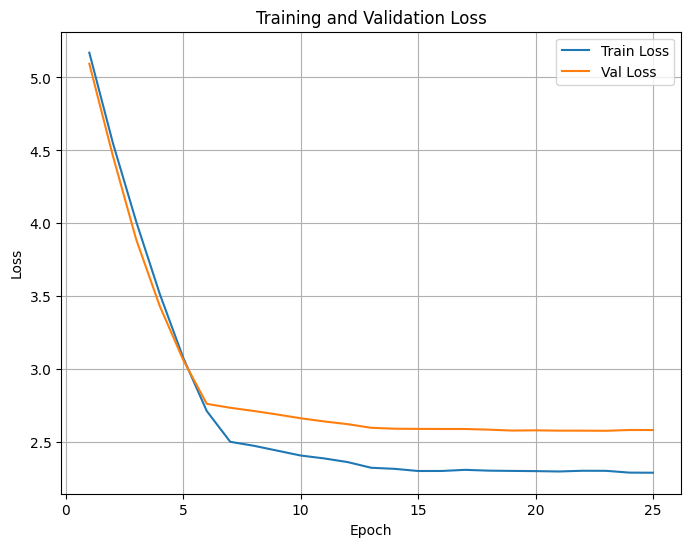

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Completed till this